In [22]:
from itertools import product

import catboost
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import sweetviz

from sklearn.model_selection import train_test_split
from nflows.distributions import ConditionalDiagonalNormal

from src.probabilistic_flow_boosting.tfboost.tree import EmbeddableCatBoostPriorNormal
from src.probabilistic_flow_boosting.tfboost.tfboost import TreeFlowBoost
from src.probabilistic_flow_boosting.tfboost.flow import ContinuousNormalizingFlow
from src.probabilistic_flow_boosting.pipelines.reporting.nodes import calculate_nll

from src.probabilistic_flow_boosting.pipelines.modeling.utils import setup_random_seed

RANDOM_SEED = 5

setup_random_seed(RANDOM_SEED)

In [2]:
def sample_mixture_of_gaussians(normal_parameters, weights = None, size = 1000):
    weights = weights if weights is not None else np.ones(normal_parameters.shape[0], dtype=np.float64) / normal_parameters.shape[0]
    mixture_idx = np.random.choice(len(weights), size=size, replace=True, p=weights)
    return np.fromiter((stats.norm.rvs(*(normal_parameters[i])) for i in mixture_idx), dtype=np.float64)


def generate_data(size):
    df1 = pd.DataFrame({'value': np.random.normal(size = size)})
    df1['X1'] = 'A'
    df1['X2'] = 'X'

    df2 = pd.DataFrame({'value': np.random.exponential(scale=3.0, size = size)})
    df2['X1'] = 'A'
    df2['X2'] = 'Y'

    df3 = pd.DataFrame({'value': sample_mixture_of_gaussians(np.array([[-10, 1], [10, 1]]), size = size)})
    df3['X1'] = 'B'
    df3['X2'] = 'X'

    df4 = pd.DataFrame({'value': np.random.gamma(shape = 7.5, scale = 1.0, size = size)})
    df4['X1'] = 'B'
    df4['X2'] = 'Y'

    df = pd.concat([df1, df2, df3, df4])
    df.index = range(len(df))
    df = df.sample(frac=1) # Shuffle dataset

    x, y = df[['X1', 'X2']], df[['value']]
    return df, x, y


def plot_distributions(dataframe, filename=None):
    fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize = (12, 8))

    axes[0][0].hist(dataframe.loc[np.logical_and(dataframe['X1'] == 'A', dataframe['X2'] == 'X'), 'value'], density=True, bins=100)
    axes[0][1].hist(dataframe.loc[np.logical_and(dataframe['X1'] == 'A', dataframe['X2'] == 'Y'), 'value'], density=True, bins=100)
    axes[1][0].hist(dataframe.loc[np.logical_and(dataframe['X1'] == 'B', dataframe['X2'] == 'X'), 'value'], density=True, bins=100)
    axes[1][1].hist(dataframe.loc[np.logical_and(dataframe['X1'] == 'B', dataframe['X2'] == 'Y'), 'value'], density=True, bins=100)

    plt.tight_layout()
    
    if filename is not None:
        plt.savefig(filename)
    else:
        plt.show()
    

def calculate_nll_catboost(model: catboost.CatBoostRegressor, x: pd.DataFrame, y: pd.DataFrame):
    x: np.ndarray = x.values
    y: np.ndarray = y.values

    if y.shape[1] > 1:
        return np.nan

    y_hat_tree = model.predict(x)
    y_hat_tree[:, 1] = np.log(np.sqrt(y_hat_tree[:, 1]))  # Transform var to log std / CatBoost RMSEWithUncertainty

    distribution = ConditionalDiagonalNormal(shape=[1])  # Assume 1D distribution
    return -distribution.log_prob(y, y_hat_tree).numpy().mean()

In [3]:
df_train, x_train, y_train = generate_data(5000)
df_val, x_val, y_val = generate_data(1000)
df_test, x_test, y_test = generate_data(500000)

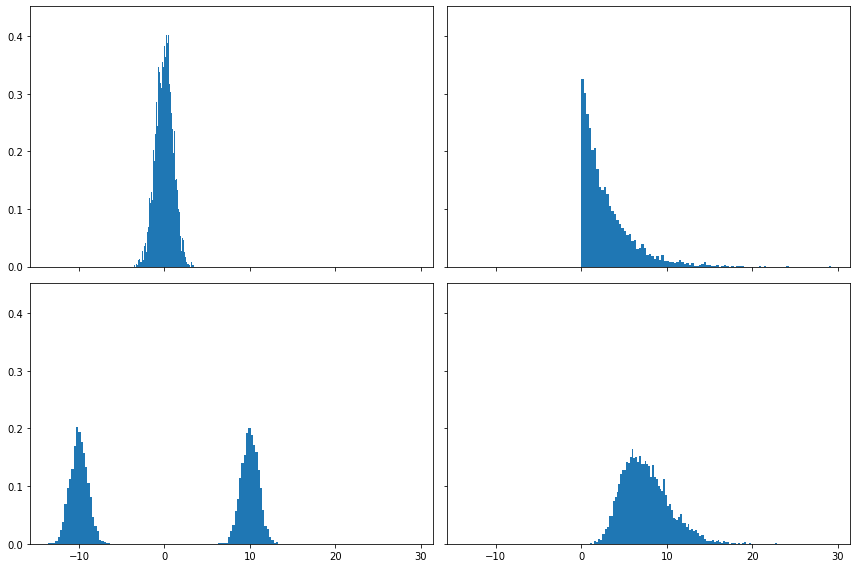

In [4]:
plot_distributions(df_train)

# CatBoost

In [5]:
model = catboost.CatBoostRegressor(
    cat_features=['X1', 'X2'], 
    loss_function="RMSEWithUncertainty",
    num_trees=1000
)

In [6]:
model.fit(x_train, y_train, eval_set=[(x_val, y_val)])

0:	learn: 3.2134020	test: 3.2038185	best: 3.2038185 (0)	total: 48.6ms	remaining: 48.6s
1:	learn: 3.1824344	test: 3.1734433	best: 3.1734433 (1)	total: 51ms	remaining: 25.5s
2:	learn: 3.1558337	test: 3.1473014	best: 3.1473014 (2)	total: 53.4ms	remaining: 17.7s
3:	learn: 3.1322912	test: 3.1241212	best: 3.1241212 (3)	total: 55.1ms	remaining: 13.7s
4:	learn: 3.1109796	test: 3.1030996	best: 3.1030996 (4)	total: 56.5ms	remaining: 11.2s
5:	learn: 3.0913519	test: 3.0837061	best: 3.0837061 (5)	total: 58ms	remaining: 9.61s
6:	learn: 3.0730335	test: 3.0655780	best: 3.0655780 (6)	total: 59.4ms	remaining: 8.43s
7:	learn: 3.0557606	test: 3.0484599	best: 3.0484599 (7)	total: 60.8ms	remaining: 7.54s
8:	learn: 3.0393426	test: 3.0321678	best: 3.0321678 (8)	total: 62.3ms	remaining: 6.86s
9:	learn: 3.0236392	test: 3.0165664	best: 3.0165664 (9)	total: 63.7ms	remaining: 6.31s
10:	learn: 3.0085452	test: 3.0015543	best: 3.0015543 (10)	total: 65.1ms	remaining: 5.86s
11:	learn: 2.9939808	test: 2.9870547	best: 2.

134:	learn: 2.5279568	test: 2.5245789	best: 2.5245789 (134)	total: 243ms	remaining: 1.56s
135:	learn: 2.5279163	test: 2.5245575	best: 2.5245575 (135)	total: 245ms	remaining: 1.55s
136:	learn: 2.5279000	test: 2.5245384	best: 2.5245384 (136)	total: 246ms	remaining: 1.55s
137:	learn: 2.5278636	test: 2.5245204	best: 2.5245204 (137)	total: 248ms	remaining: 1.55s
138:	learn: 2.5278299	test: 2.5245044	best: 2.5245044 (138)	total: 249ms	remaining: 1.54s
139:	learn: 2.5277987	test: 2.5244901	best: 2.5244901 (139)	total: 251ms	remaining: 1.54s
140:	learn: 2.5277822	test: 2.5244813	best: 2.5244813 (140)	total: 252ms	remaining: 1.53s
141:	learn: 2.5277543	test: 2.5244693	best: 2.5244693 (141)	total: 253ms	remaining: 1.53s
142:	learn: 2.5277285	test: 2.5244587	best: 2.5244587 (142)	total: 255ms	remaining: 1.53s
143:	learn: 2.5277045	test: 2.5244494	best: 2.5244494 (143)	total: 256ms	remaining: 1.52s
144:	learn: 2.5276823	test: 2.5244411	best: 2.5244411 (144)	total: 258ms	remaining: 1.52s
145:	learn

272:	learn: 2.5273742	test: 2.5244600	best: 2.5243846 (170)	total: 438ms	remaining: 1.17s
273:	learn: 2.5273742	test: 2.5244603	best: 2.5243846 (170)	total: 440ms	remaining: 1.16s
274:	learn: 2.5273741	test: 2.5244605	best: 2.5243846 (170)	total: 441ms	remaining: 1.16s
275:	learn: 2.5273741	test: 2.5244607	best: 2.5243846 (170)	total: 442ms	remaining: 1.16s
276:	learn: 2.5273741	test: 2.5244607	best: 2.5243846 (170)	total: 444ms	remaining: 1.16s
277:	learn: 2.5273741	test: 2.5244610	best: 2.5243846 (170)	total: 445ms	remaining: 1.16s
278:	learn: 2.5273741	test: 2.5244613	best: 2.5243846 (170)	total: 447ms	remaining: 1.15s
279:	learn: 2.5273741	test: 2.5244614	best: 2.5243846 (170)	total: 448ms	remaining: 1.15s
280:	learn: 2.5273740	test: 2.5244617	best: 2.5243846 (170)	total: 449ms	remaining: 1.15s
281:	learn: 2.5273740	test: 2.5244617	best: 2.5243846 (170)	total: 451ms	remaining: 1.15s
282:	learn: 2.5273740	test: 2.5244619	best: 2.5243846 (170)	total: 452ms	remaining: 1.15s
283:	learn

411:	learn: 2.5273737	test: 2.5244684	best: 2.5243846 (170)	total: 633ms	remaining: 904ms
412:	learn: 2.5273737	test: 2.5244684	best: 2.5243846 (170)	total: 635ms	remaining: 902ms
413:	learn: 2.5273737	test: 2.5244684	best: 2.5243846 (170)	total: 636ms	remaining: 900ms
414:	learn: 2.5273737	test: 2.5244684	best: 2.5243846 (170)	total: 637ms	remaining: 898ms
415:	learn: 2.5273737	test: 2.5244684	best: 2.5243846 (170)	total: 639ms	remaining: 897ms
416:	learn: 2.5273737	test: 2.5244684	best: 2.5243846 (170)	total: 640ms	remaining: 895ms
417:	learn: 2.5273737	test: 2.5244684	best: 2.5243846 (170)	total: 641ms	remaining: 893ms
418:	learn: 2.5273737	test: 2.5244684	best: 2.5243846 (170)	total: 643ms	remaining: 891ms
419:	learn: 2.5273737	test: 2.5244685	best: 2.5243846 (170)	total: 644ms	remaining: 890ms
420:	learn: 2.5273737	test: 2.5244685	best: 2.5243846 (170)	total: 646ms	remaining: 888ms
421:	learn: 2.5273737	test: 2.5244685	best: 2.5243846 (170)	total: 647ms	remaining: 886ms
422:	learn

545:	learn: 2.5273737	test: 2.5244687	best: 2.5243846 (170)	total: 829ms	remaining: 689ms
546:	learn: 2.5273737	test: 2.5244687	best: 2.5243846 (170)	total: 830ms	remaining: 687ms
547:	learn: 2.5273737	test: 2.5244687	best: 2.5243846 (170)	total: 831ms	remaining: 686ms
548:	learn: 2.5273737	test: 2.5244687	best: 2.5243846 (170)	total: 833ms	remaining: 684ms
549:	learn: 2.5273737	test: 2.5244687	best: 2.5243846 (170)	total: 834ms	remaining: 683ms
550:	learn: 2.5273737	test: 2.5244687	best: 2.5243846 (170)	total: 836ms	remaining: 681ms
551:	learn: 2.5273737	test: 2.5244687	best: 2.5243846 (170)	total: 837ms	remaining: 680ms
552:	learn: 2.5273737	test: 2.5244687	best: 2.5243846 (170)	total: 839ms	remaining: 678ms
553:	learn: 2.5273737	test: 2.5244687	best: 2.5243846 (170)	total: 840ms	remaining: 677ms
554:	learn: 2.5273737	test: 2.5244687	best: 2.5243846 (170)	total: 842ms	remaining: 675ms
555:	learn: 2.5273737	test: 2.5244687	best: 2.5243846 (170)	total: 843ms	remaining: 673ms
556:	learn

679:	learn: 2.5273737	test: 2.5244687	best: 2.5243846 (170)	total: 1.02s	remaining: 482ms
680:	learn: 2.5273737	test: 2.5244687	best: 2.5243846 (170)	total: 1.03s	remaining: 481ms
681:	learn: 2.5273737	test: 2.5244687	best: 2.5243846 (170)	total: 1.03s	remaining: 479ms
682:	learn: 2.5273737	test: 2.5244687	best: 2.5243846 (170)	total: 1.03s	remaining: 478ms
683:	learn: 2.5273737	test: 2.5244687	best: 2.5243846 (170)	total: 1.03s	remaining: 476ms
684:	learn: 2.5273737	test: 2.5244687	best: 2.5243846 (170)	total: 1.03s	remaining: 475ms
685:	learn: 2.5273737	test: 2.5244687	best: 2.5243846 (170)	total: 1.03s	remaining: 473ms
686:	learn: 2.5273737	test: 2.5244687	best: 2.5243846 (170)	total: 1.03s	remaining: 472ms
687:	learn: 2.5273737	test: 2.5244687	best: 2.5243846 (170)	total: 1.04s	remaining: 470ms
688:	learn: 2.5273737	test: 2.5244687	best: 2.5243846 (170)	total: 1.04s	remaining: 469ms
689:	learn: 2.5273737	test: 2.5244687	best: 2.5243846 (170)	total: 1.04s	remaining: 467ms
690:	learn

812:	learn: 2.5273737	test: 2.5244687	best: 2.5243846 (170)	total: 1.22s	remaining: 281ms
813:	learn: 2.5273737	test: 2.5244687	best: 2.5243846 (170)	total: 1.22s	remaining: 279ms
814:	learn: 2.5273737	test: 2.5244687	best: 2.5243846 (170)	total: 1.22s	remaining: 277ms
815:	learn: 2.5273737	test: 2.5244687	best: 2.5243846 (170)	total: 1.22s	remaining: 276ms
816:	learn: 2.5273737	test: 2.5244687	best: 2.5243846 (170)	total: 1.23s	remaining: 274ms
817:	learn: 2.5273737	test: 2.5244687	best: 2.5243846 (170)	total: 1.23s	remaining: 273ms
818:	learn: 2.5273737	test: 2.5244687	best: 2.5243846 (170)	total: 1.23s	remaining: 271ms
819:	learn: 2.5273737	test: 2.5244687	best: 2.5243846 (170)	total: 1.23s	remaining: 270ms
820:	learn: 2.5273737	test: 2.5244687	best: 2.5243846 (170)	total: 1.23s	remaining: 268ms
821:	learn: 2.5273737	test: 2.5244687	best: 2.5243846 (170)	total: 1.23s	remaining: 267ms
822:	learn: 2.5273737	test: 2.5244687	best: 2.5243846 (170)	total: 1.23s	remaining: 265ms
823:	learn

945:	learn: 2.5273737	test: 2.5244687	best: 2.5243846 (170)	total: 1.41s	remaining: 80.7ms
946:	learn: 2.5273737	test: 2.5244687	best: 2.5243846 (170)	total: 1.42s	remaining: 79.2ms
947:	learn: 2.5273737	test: 2.5244687	best: 2.5243846 (170)	total: 1.42s	remaining: 77.8ms
948:	learn: 2.5273737	test: 2.5244687	best: 2.5243846 (170)	total: 1.42s	remaining: 76.3ms
949:	learn: 2.5273737	test: 2.5244687	best: 2.5243846 (170)	total: 1.42s	remaining: 74.8ms
950:	learn: 2.5273737	test: 2.5244687	best: 2.5243846 (170)	total: 1.42s	remaining: 73.3ms
951:	learn: 2.5273737	test: 2.5244687	best: 2.5243846 (170)	total: 1.42s	remaining: 71.8ms
952:	learn: 2.5273737	test: 2.5244687	best: 2.5243846 (170)	total: 1.42s	remaining: 70.3ms
953:	learn: 2.5273737	test: 2.5244687	best: 2.5243846 (170)	total: 1.43s	remaining: 68.8ms
954:	learn: 2.5273737	test: 2.5244687	best: 2.5243846 (170)	total: 1.43s	remaining: 67.3ms
955:	learn: 2.5273737	test: 2.5244687	best: 2.5243846 (170)	total: 1.43s	remaining: 65.8ms

In [7]:
calculate_nll_catboost(model, x_train, y_train)

2.5274505906395333

In [8]:
calculate_nll_catboost(model, x_test, y_test)

2.521639413315708

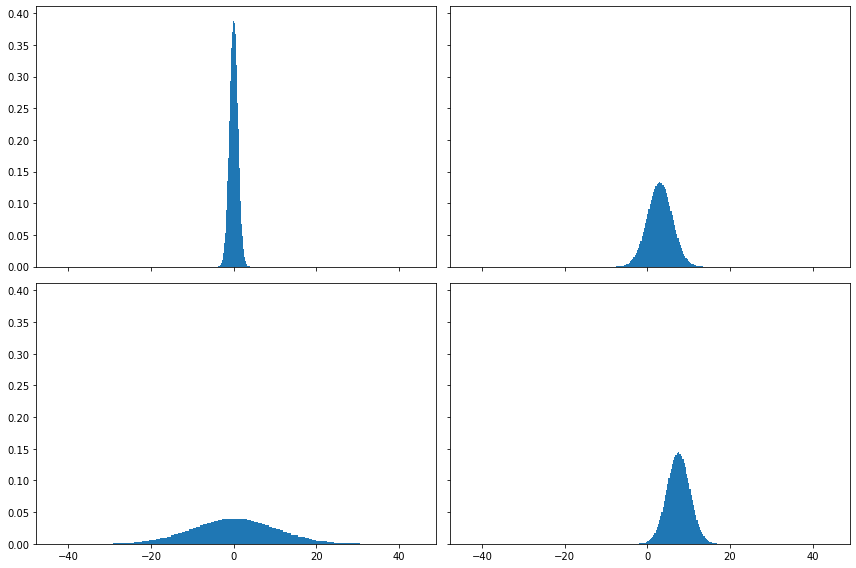

In [9]:
catboost_samples = x_test.copy()
pred = model.predict(x_test)
catboost_samples['value'] = [stats.norm.rvs(loc = pred[i, 0], scale = np.sqrt(pred[i, 1])) for i in range(len(pred))]

plot_distributions(catboost_samples)

# TreeFlow

In [10]:
tree = EmbeddableCatBoostPriorNormal(
    cat_features=[0, 1], 
    loss_function="RMSEWithUncertainty",
    depth=2,
    num_trees=100,
)
flow = ContinuousNormalizingFlow(input_dim=1, hidden_dims=(50, 10), 
                                 num_blocks=2, context_dim=50, conditional=True)

treeflow = TreeFlowBoost(tree, flow, embedding_size=50)

In [11]:
treeflow.fit(x_train.values, y_train.values, x_val.values, y_val.values, n_epochs=50, batch_size=1024, verbose=True)

0:	learn: 3.2134020	total: 1.45ms	remaining: 144ms
1:	learn: 3.1824344	total: 2.81ms	remaining: 138ms
2:	learn: 3.1558337	total: 4.15ms	remaining: 134ms
3:	learn: 3.1322912	total: 5.46ms	remaining: 131ms
4:	learn: 3.1109796	total: 6.77ms	remaining: 129ms
5:	learn: 3.0913519	total: 8.09ms	remaining: 127ms
6:	learn: 3.0730335	total: 9.32ms	remaining: 124ms
7:	learn: 3.0557606	total: 10.5ms	remaining: 121ms
8:	learn: 3.0393426	total: 11.8ms	remaining: 119ms
9:	learn: 3.0236392	total: 13ms	remaining: 117ms
10:	learn: 3.0085452	total: 14.2ms	remaining: 115ms
11:	learn: 2.9939808	total: 15.4ms	remaining: 113ms
12:	learn: 2.9798840	total: 16.7ms	remaining: 112ms
13:	learn: 2.9662069	total: 17.9ms	remaining: 110ms
14:	learn: 2.9529114	total: 19.2ms	remaining: 109ms
15:	learn: 2.9399672	total: 20.4ms	remaining: 107ms
16:	learn: 2.9273499	total: 21.6ms	remaining: 106ms
17:	learn: 2.9150397	total: 22.9ms	remaining: 104ms
18:	learn: 2.9030202	total: 24.1ms	remaining: 103ms
19:	learn: 2.8912779	tot

TreeFlowBoost(embedding_size=50,
              flow_model=<src.probabilistic_flow_boosting.tfboost.flow.flow.ContinuousNormalizingFlow object at 0x7ff5d00d8668>,
              tree_model=<src.probabilistic_flow_boosting.tfboost.tree.ecatboost.EmbeddableCatBoostPriorNormal object at 0x7ff5d00d8fd0>)

In [12]:
calculate_nll(treeflow, x_train, y_train, batch_size = 1024)

2.0043848

In [13]:
calculate_nll(treeflow, x_test, y_test, batch_size = 1024)

2.0178707

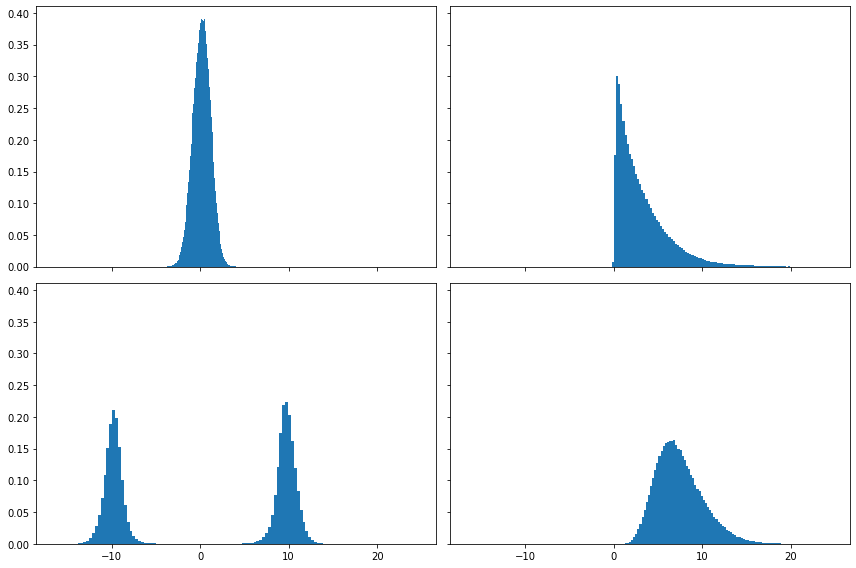

In [14]:
treeflow_samples = x_test.copy()
treeflow_samples['value'] = treeflow.sample(treeflow_samples.values, num_samples=1).squeeze()

plot_distributions(treeflow_samples)

## Comparison plot

In [25]:
for x1, x2 in product(["A", "B"], ["X", "Y"]):
    sns.kdeplot(df_test.loc[np.logical_and(df_test['X1'] == x1, df_test['X2'] == x2), 'value'], lw = 2, color='red', label='True dist.')
    sns.kdeplot(catboost_samples.loc[np.logical_and(catboost_samples['X1'] == x1, catboost_samples['X2'] == x2), 'value'], lw = 2, color='orange', label='CatBoost')
    sns.kdeplot(treeflow_samples.loc[np.logical_and(treeflow_samples['X1'] == x1, treeflow_samples['X2'] == x2), 'value'], lw = 2, color='blue', label='TreeFlow')
    plt.tight_layout()
    # plt.legend()
    plt.savefig(f'very_toy_example_{x1}_{x2}.pdf')
    plt.close()
    